# ProdLDA

In [1]:
from octis.preprocessing.preprocessing import Preprocessing
from octis.models.ProdLDA import ProdLDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real
import torch
import numpy as np
import pandas as pd
import string
import os
from wordcloud import WordCloud
from skopt.space.space import Integer, Real
import time
import matplotlib.pyplot as plt
import json
import spacy
from tqdm import tqdm


In [2]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

In [3]:
data_path = 'data/input'
corpus_path = 'data/input/corpus.txt'
label_path = 'data/input/labels.txt'
proc_path = 'data/processed/dataset'
frac = 0.25

In [4]:
from preprocessing.prod_clean_text import *

## Data Setup and preprocessing

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
extract_corpus_and_labels_from_songs_csv(csv_input_path = 'data/raw/cleaned_train_lyrics.csv', output_path = data_path,frac=frac)

Corpus has been saved to data/input_small\corpus.txt
Labels have been saved to data/input_small\labels.txt


In [7]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 10,
                             max_df = 0.85,
                             remove_punctuation = True,
                             punctuation = string.punctuation,
                             remove_numbers = True,
                             lemmatize = True,
                             stopword_list = CUSTOM_STOPWORDS,
                             min_chars = 3,
                             min_words_docs = 10,
                             language = 'english',
                             split = True,
                             verbose = True)

In [8]:
# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists(proc_path):
    dataset = preprocessor.preprocess_dataset(documents_path = corpus_path,labels_path = label_path)
    dataset.save(proc_path)
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder(proc_path)

In [9]:
dataset.get_metadata()

{'total_documents': 500,
 'vocabulary_length': 410,
 'preprocessing-info': ['lowercase',
  'remove_punctuation',
  'lemmatize',
  'filter words with document frequency lower than 20 and higher than 0.8',
  'filter words with less than 3 character',
  'filter documents with less than 10 words'],
 'last-training-doc': 345,
 'last-validation-doc': 419}

## Metrics

In [10]:
dummy_run = False

if(dummy_run):
    num_iters = 5
    number_of_calls = 2
else:
    num_iters = 15
    number_of_calls = 15 # Bottleneck for computation time

In [11]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk=10, measure = 'c_uci') # Initialize metric

## Prod LDA model without optimization

In [12]:
N_TOPICS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#current_device = torch.cuda.current_device()
#print(f"Currently using GPU: {current_device}")
#print(f"GPU Name: {torch.cuda.get_device_name(current_device)}")

Device: cpu


In [13]:
model = ProdLDA(num_topics = N_TOPICS, 
               activation = 'softplus', 
               dropout = 0.2,
               learn_priors = True, 
               batch_size = 64, 
               lr = 2e-3, 
               momentum = 0.99,
               solver = 'adam', 
               num_epochs = 100, 
               reduce_on_plateau = False, 
               prior_mean = 0.0,
               prior_variance = None, 
               num_layers = 2, 
               num_neurons = 100, 
               num_samples = 10,
               use_partitions = True)

In [15]:
coherence_list_no_opt, topic_diversity_list_no_opt = [], []

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset, hyperparameters=None, top_words=10)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 752.4884567481884	Time: 0:00:00.199981
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.9637748099663	Time: 0:00:00.016069
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 741.9401324728261	Time: 0:00:00.016789
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 717.812961887669	Time: 0:00:00.015951
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 733.9863705842391	Time: 0:00:00.016576
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 717.899486644848	Time: 0:00:00.016714
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 735.1051403985507	Time: 0:00:00.016438
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.3787742820946	Time: 0:00:00.016982
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 727.862013134058	Time: 0:00:00.016591
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 718.250415698902	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 723.9576426630434	Time: 0:00:00.033308
Epoch: [6/100]	Samples: [74/7400]	V

 20%|██        | 1/5 [00:03<00:14,  3.59s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 755.9938519021739	Time: 0:00:00.031247
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 718.0269676414696	Time: 0:00:00.018420
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 746.8085258152174	Time: 0:00:00.031642
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 718.3396062077703	Time: 0:00:00
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 751.0477864583333	Time: 0:00:00.018672
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 718.9803895692568	Time: 0:00:00.015683
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 739.3357280344203	Time: 0:00:00.015630
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 719.0634633657095	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 736.4252094655797	Time: 0:00:00.032700
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 719.2916622677365	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 731.6993602807971	Time: 0:00:00.035559
Epoch: [6/100]	Samples: [74/7400]	Validation 

 40%|████      | 2/5 [00:04<00:06,  2.02s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 748.433840013587	Time: 0:00:00.031169
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.4005555848818	Time: 0:00:00
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 750.2703917572463	Time: 0:00:00.018767
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 717.2957334776182	Time: 0:00:00
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 744.4806216032608	Time: 0:00:00.035635
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 718.0412399704392	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 745.7687726449275	Time: 0:00:00.031435
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.2408348289696	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 739.3598930027174	Time: 0:00:00.031247
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 718.7385715793919	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 731.4821218297102	Time: 0:00:00.031298
Epoch: [6/100]	Samples: [74/7400]	Validation Loss: 717.74520

 60%|██████    | 3/5 [00:05<00:03,  1.56s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 753.7097995923913	Time: 0:00:00.023546
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.4698849239865	Time: 0:00:00.004008
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 744.0894134963768	Time: 0:00:00.026068
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 717.6993375211149	Time: 0:00:00.007800
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 742.5778957201087	Time: 0:00:00.017404
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 717.6817461993244	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 731.8590070199275	Time: 0:00:00.040690
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 718.1491996146538	Time: 0:00:00.002990
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 729.791060914855	Time: 0:00:00.025319
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 718.8256967905405	Time: 0:00:00.002987
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 724.7833446557971	Time: 0:00:00.014164
Epoch: [6/100]	Samples: [74/7400

 80%|████████  | 4/5 [00:06<00:01,  1.30s/it]

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 748.9026268115942	Time: 0:00:00.033151
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.2970333614865	Time: 0:00:00
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 739.9152909873188	Time: 0:00:00.017153
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 717.2131941511824	Time: 0:00:00.016628
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 736.9179913949275	Time: 0:00:00.016707
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 717.7891812711149	Time: 0:00:00.019038
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 730.6686933876812	Time: 0:00:00.014288
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 717.9395586993244	Time: 0:00:00.016910
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 725.2308876811594	Time: 0:00:00.016399
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 717.0765347867399	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 719.7438547327898	Time: 0:00:00.033234
Epoch: [6/100]	Samples: [74/7400]	Vali

100%|██████████| 5/5 [00:08<00:00,  1.67s/it]

Mean coherence:  0.3074521113250213 
Mean topic diversity:  0.688


## Prod LDA model with optimization

In [16]:
model = ProdLDA()

In [17]:
# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "lr": Real(low=1e-3, high=0.01),} 

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

2


In [18]:
start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path = "results/test_ProdLDA", # path to store the results
                            number_of_call = number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs = num_iters, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen = True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123,
                            save_models = True,
                            topk=20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')
results = json.load(open("results/test_ProdLDA/result.json",'r'))

Current call:  0
Epoch: [1/100]	Samples: [345/34500]	Train Loss: 756.2074048913043	Time: 0:00:00.025329
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 727.137180637669	Time: 0:00:00
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 760.251030344203	Time: 0:00:00.052074
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 740.9660578547297	Time: 0:00:00.007117
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 735.2949558423913	Time: 0:00:00.046868
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 727.6834155933277	Time: 0:00:00.006302
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 736.2557631340579	Time: 0:00:00.043250
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 729.7690561655405	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 722.0785778985507	Time: 0:00:00.033446
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 719.721607105152	Time: 0:00:00
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 719.6741904438405	Time: 0:00:00.034476
Epoch: [6/100]	Samples: [74/740

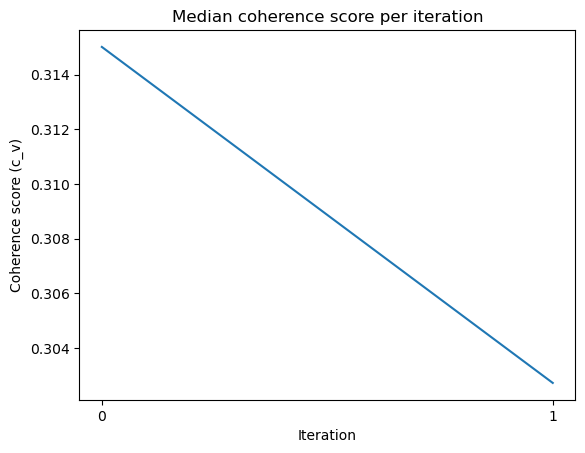

In [19]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.xticks(range(len(results["f_val"])))
plt.show()

In [20]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


0.3150157341114765


In [21]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
lr = results["x_iters"]["lr"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal learning rate: ", lr)

dict_keys(['dropout', 'lr', 'num_topics'])
Optimal number of topics:  16
Optimal dropout:  0.41840902737637237
Optimal learning rate:  0.006313971035362703


In [22]:
model = ProdLDA(num_topics=num_topics, lr=lr)

In [23]:
coherence_list, topic_diversity_list, outputs = [], [], []

for i in range(num_iters):
  output = model.train_model(dataset, top_words=10)
  outputs.append(output)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 752.8170289855072	Time: 0:00:00.035790
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 720.246337890625	Time: 0:00:00.002996
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 742.8370414402174	Time: 0:00:00.026354
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 723.4538772170608	Time: 0:00:00
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 735.4402060688406	Time: 0:00:00.033081
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 738.4281434755068	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 737.8834465579711	Time: 0:00:00.034887
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 736.5832321579392	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 718.8218636775363	Time: 0:00:00.032401
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 718.4577570734797	Time: 0:00:00.016191
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 718.7839560688406	Time: 0:00:00.032362
Epoch: [6/100]	Samples: [74/7400]	Validation L

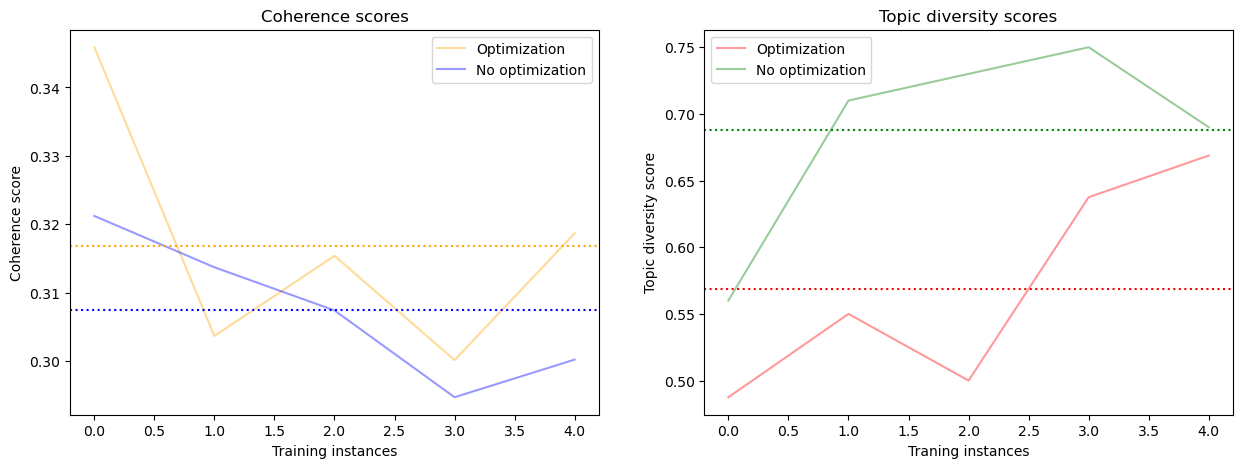

In [24]:

# Plot of the coherences of the models (no opt vs opt) and the topic diversity of the models (no opt vs opt).
# Two plots side by side 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()




In [ ]:
# Extract the best output from the outputs list according to a linear combination of the coherence and topic diversity scores

best_output = outputs[np.argmax([0.7*coherence_list[i] + 0.3*topic_diversity_list[i] for i in range(len(coherence_list))])]


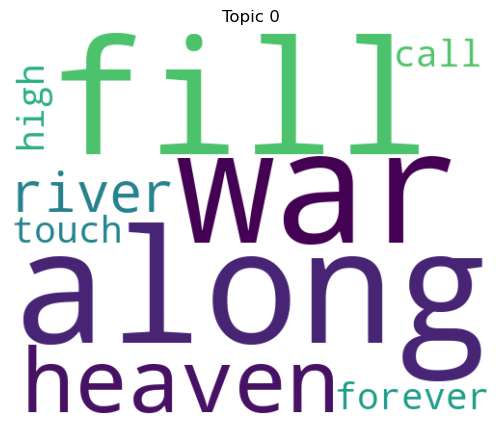

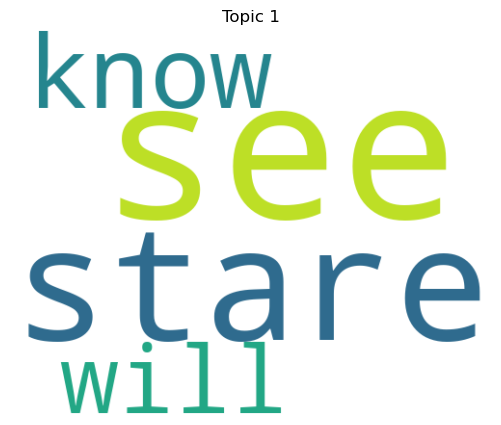

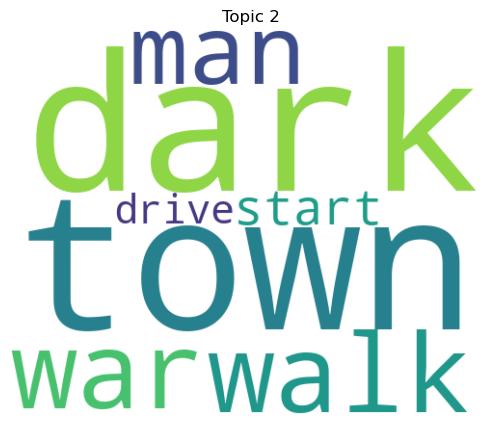

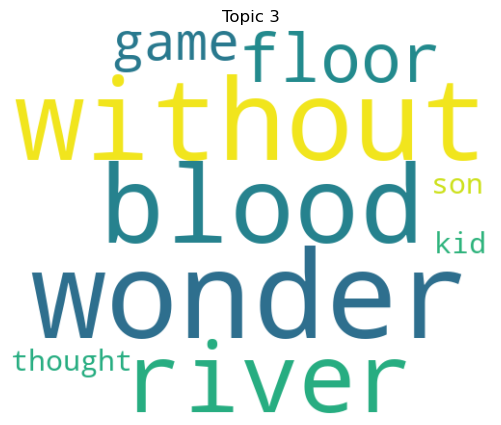

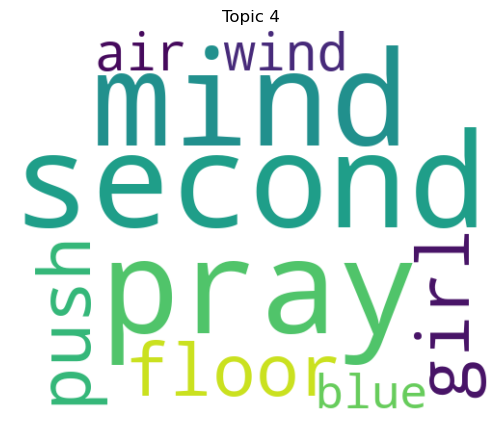

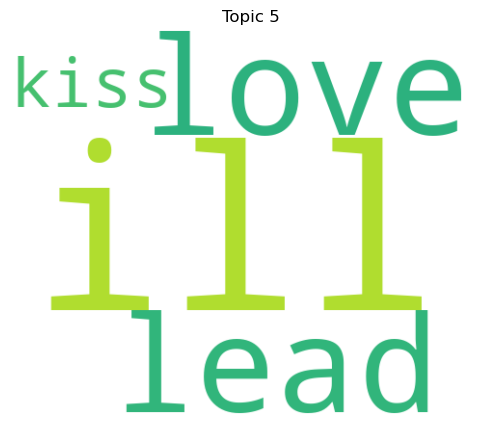

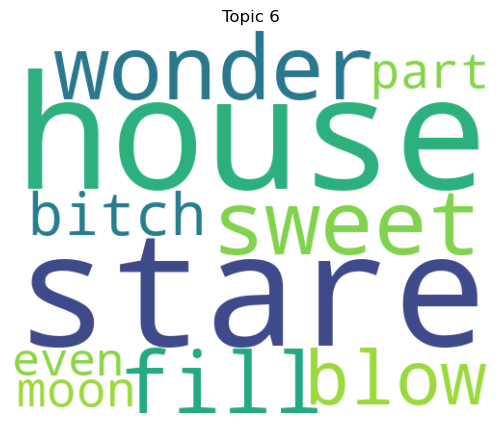

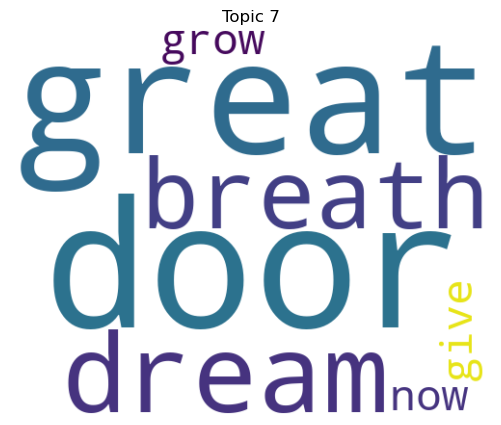

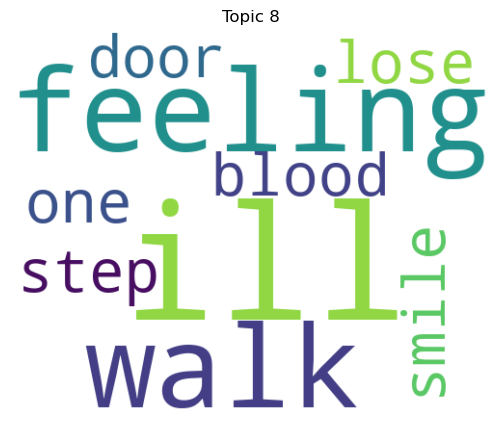

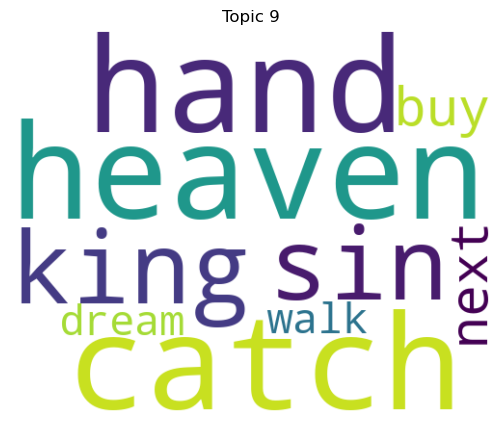

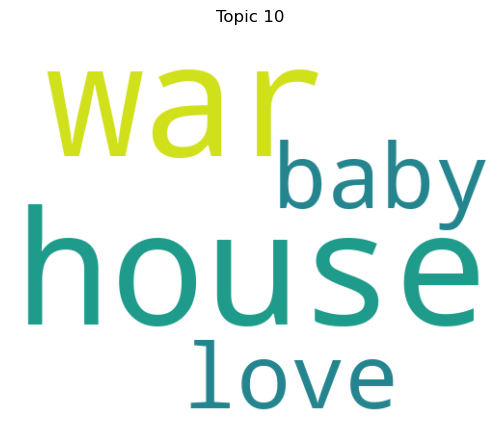

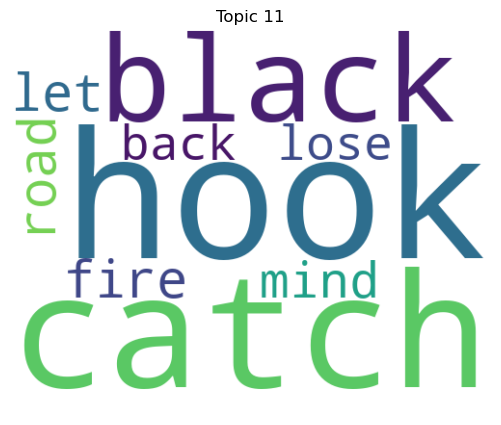

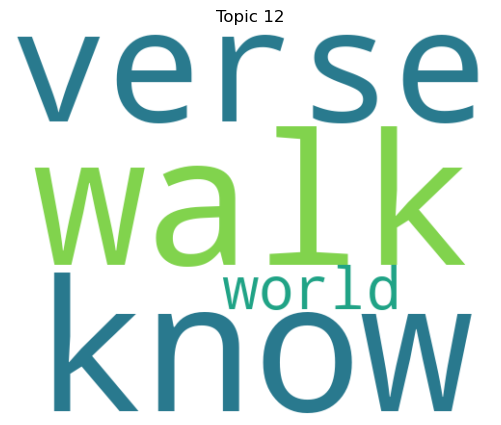

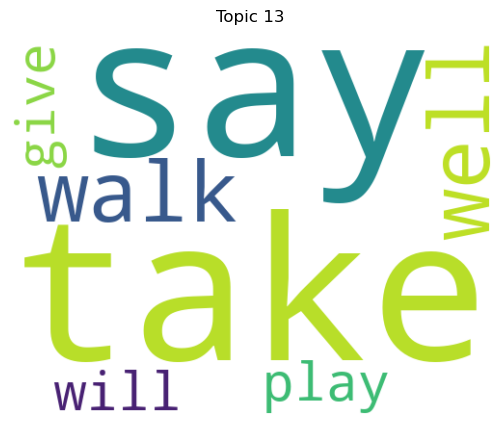

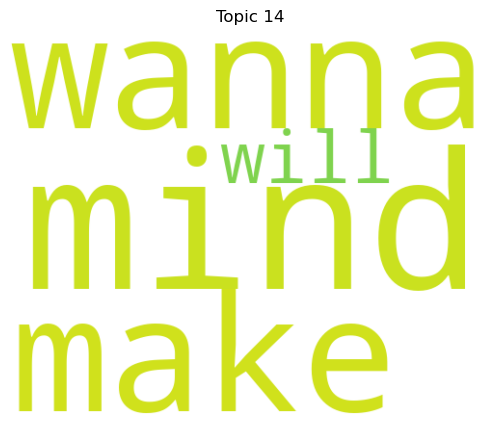

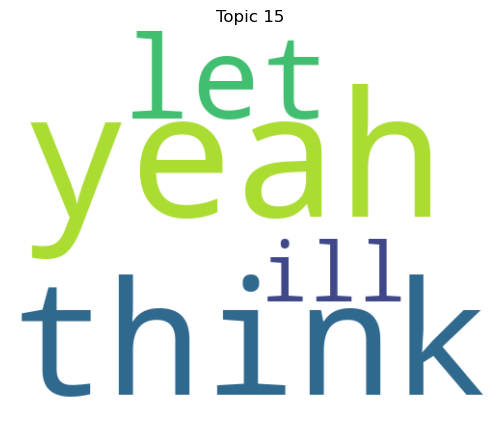

In [25]:
topics = best_output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=500, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()

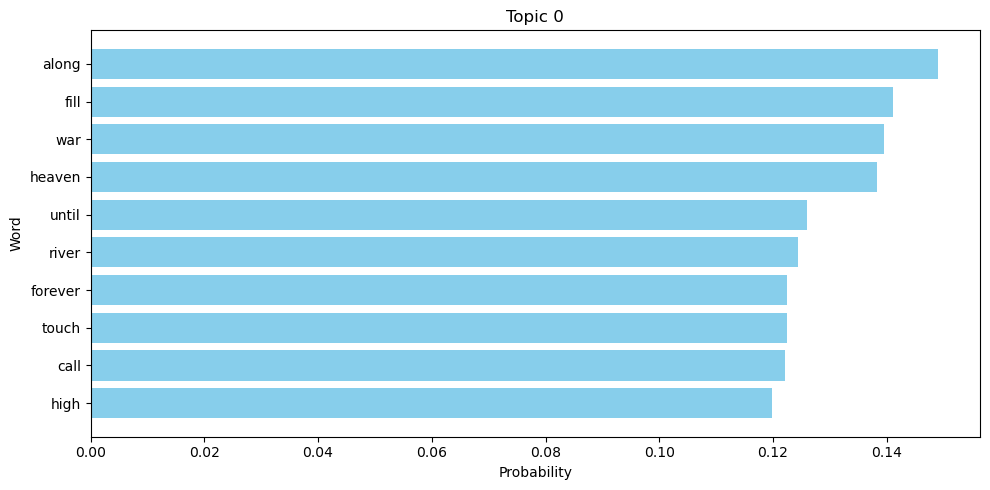

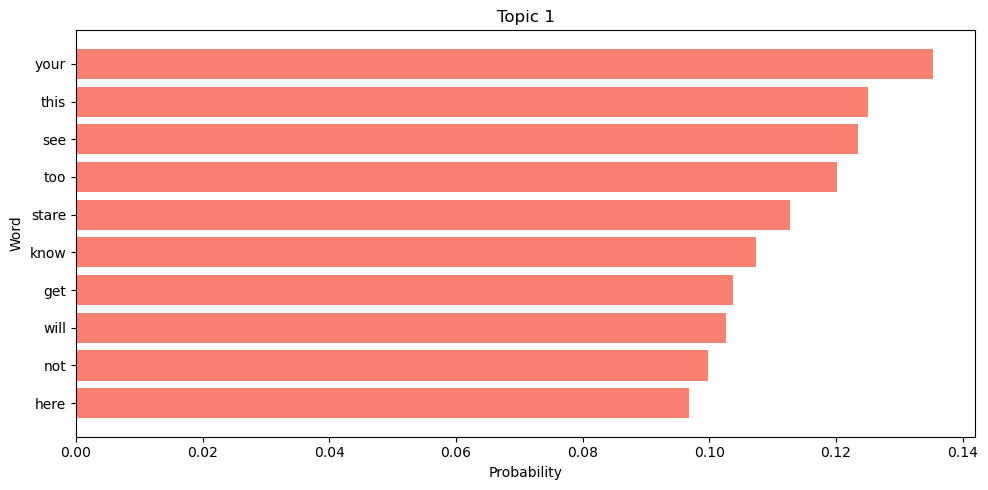

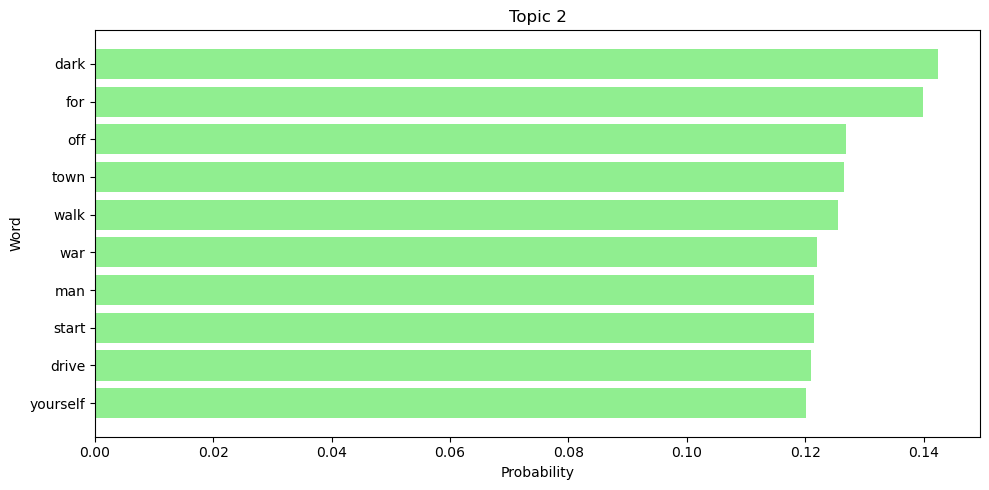

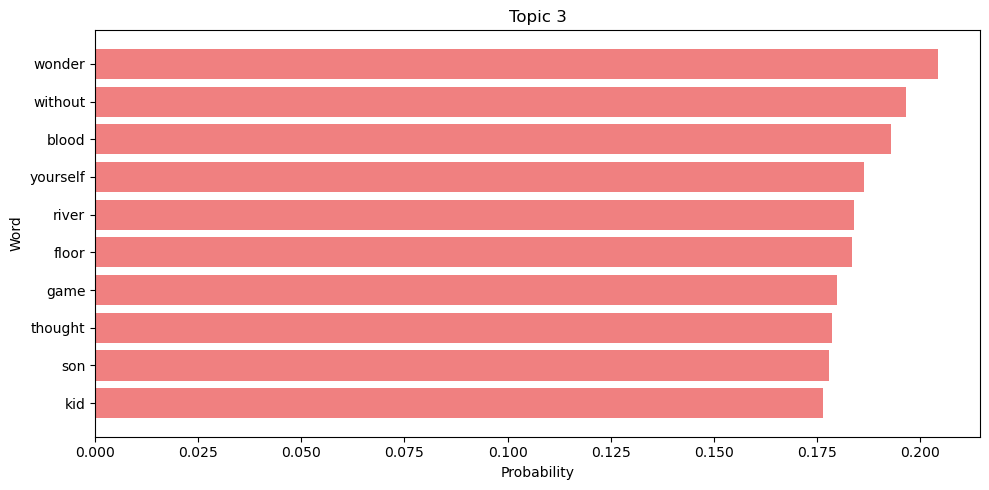

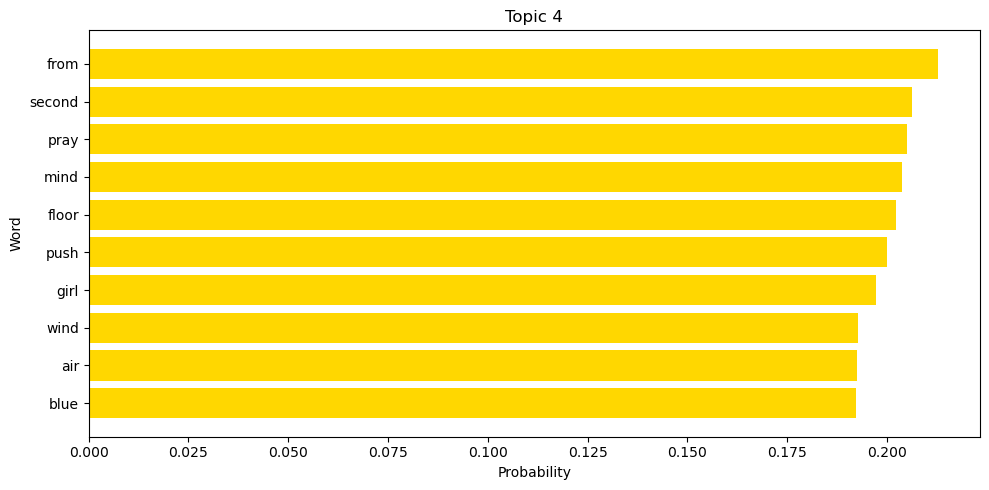

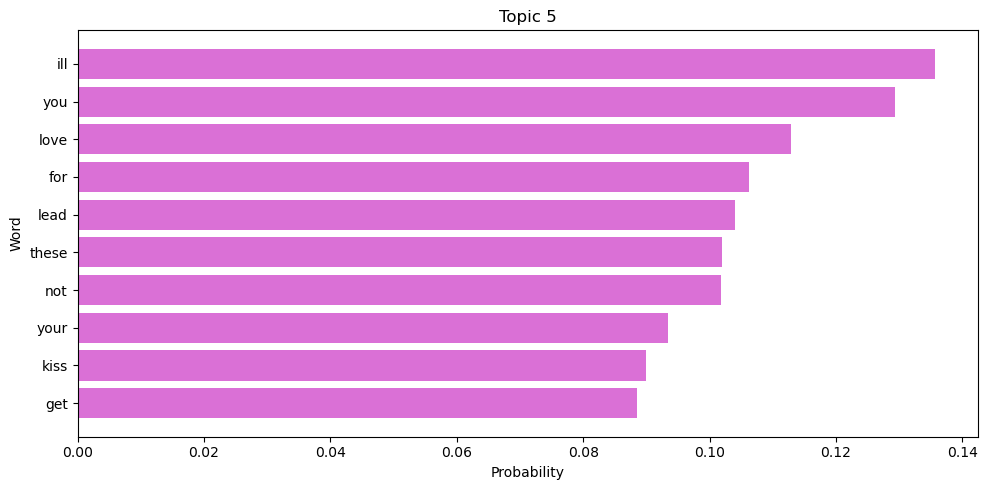

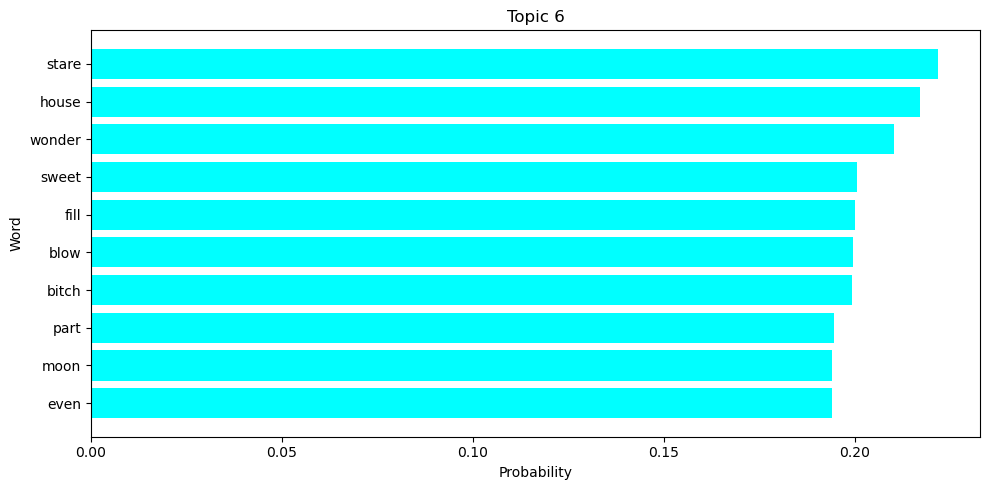

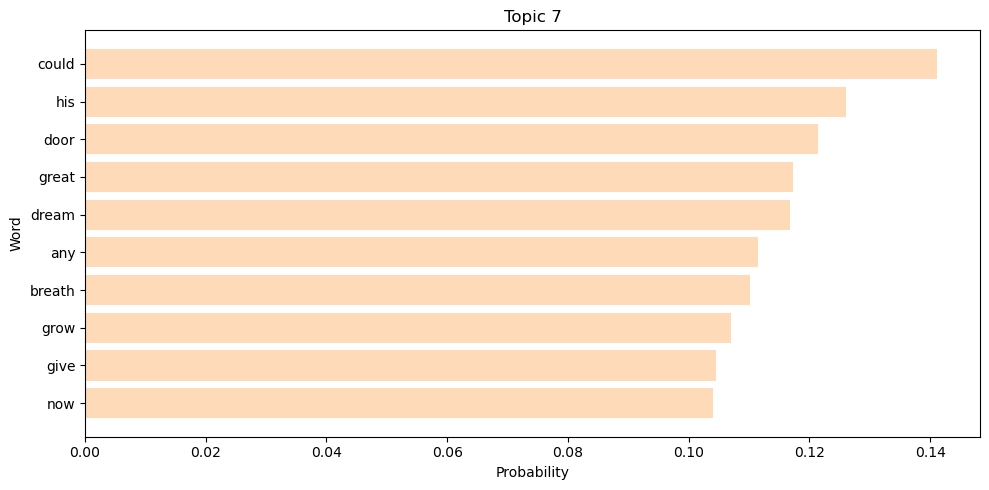

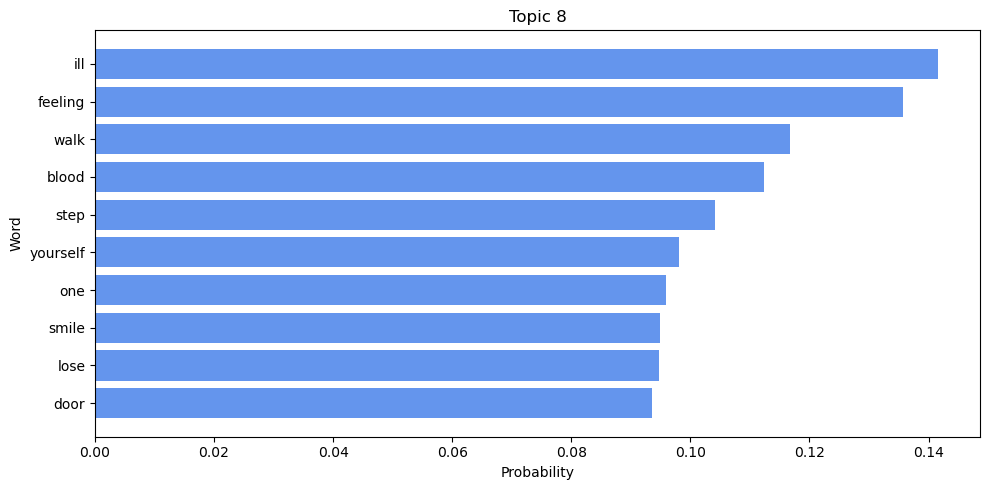

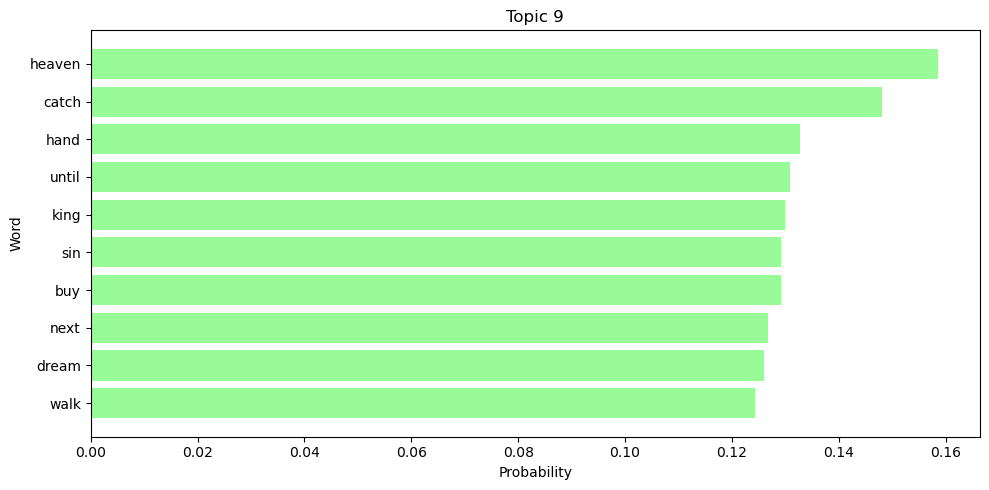

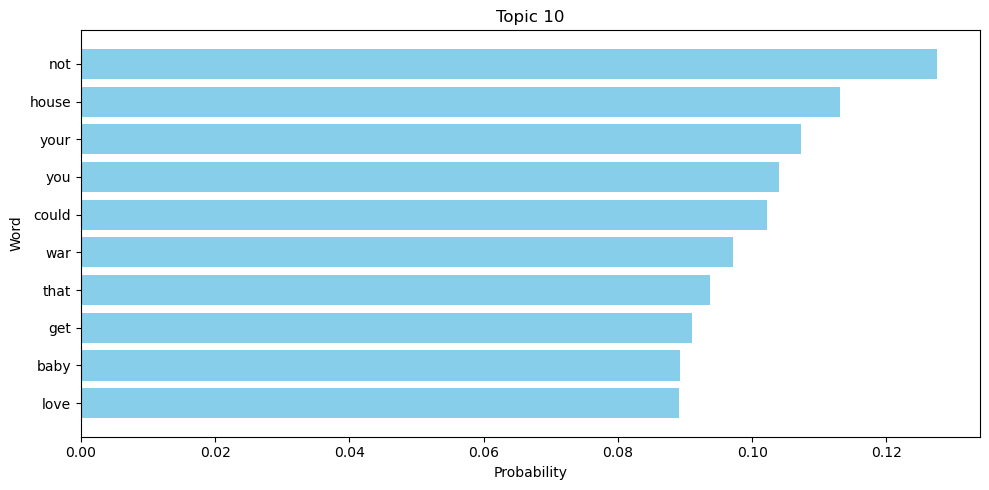

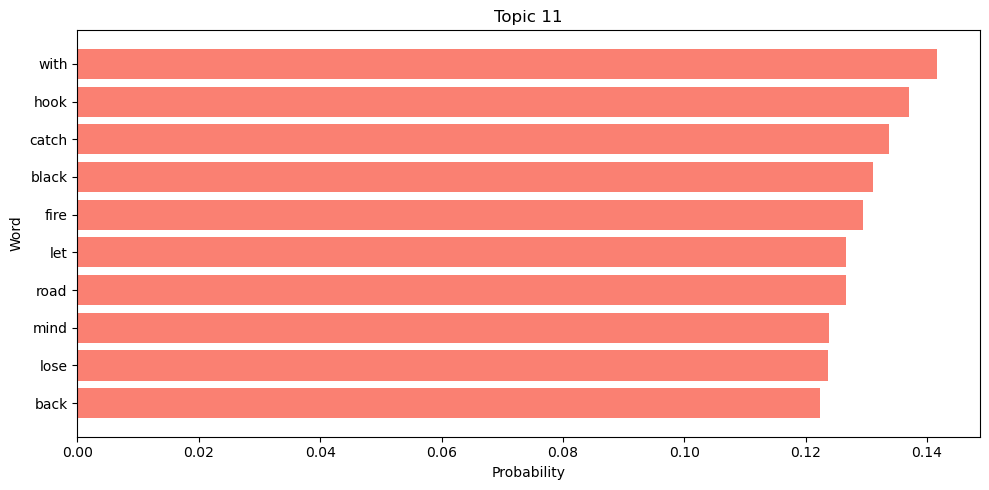

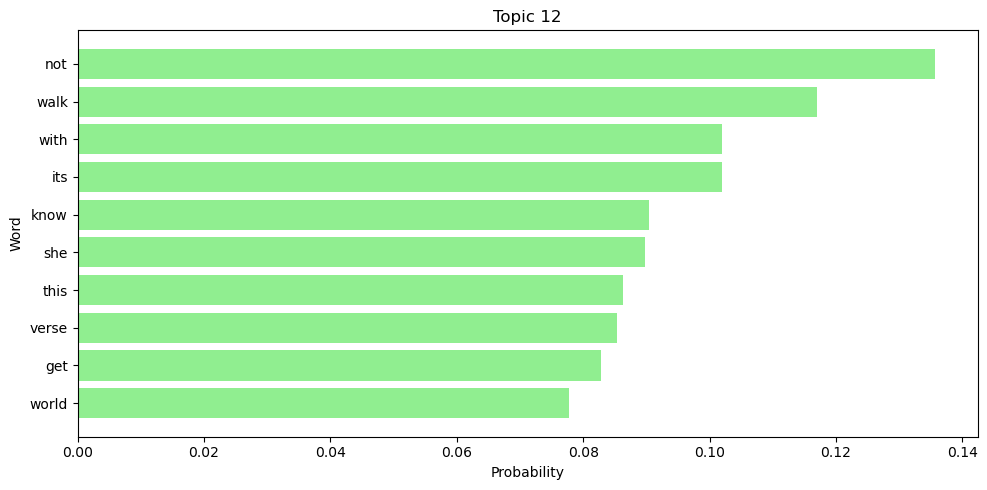

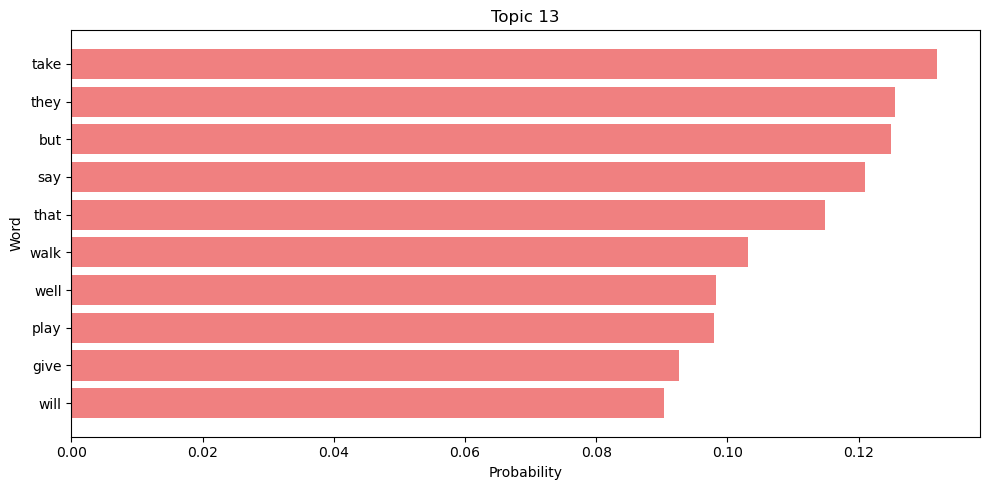

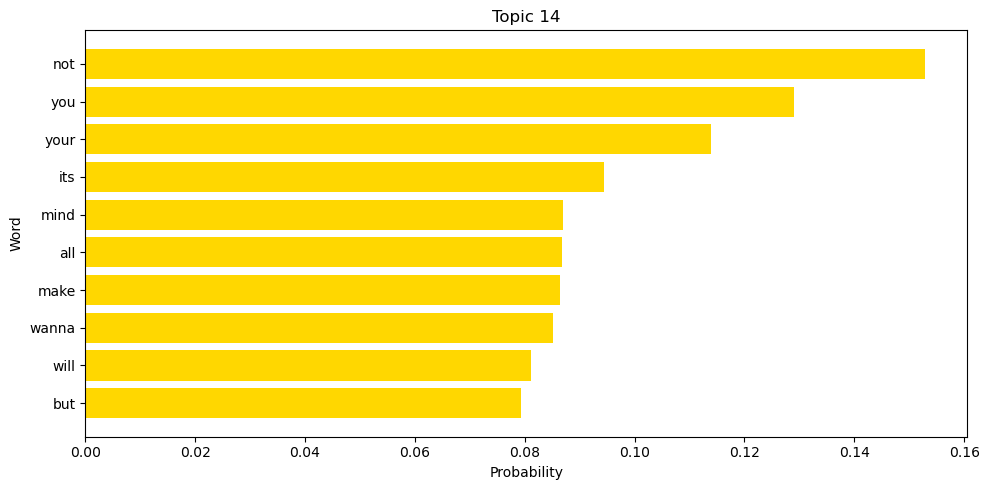

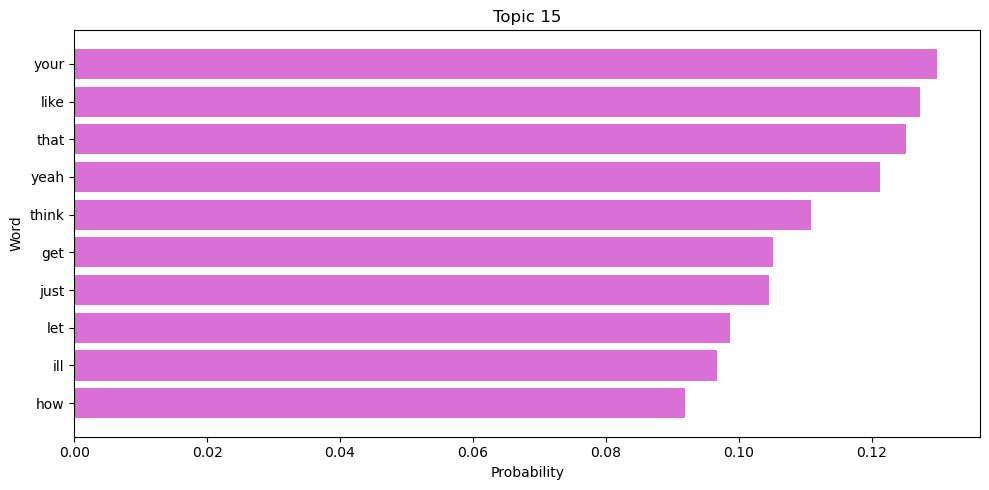

In [26]:
topic_word_matrix = best_output['topic-word-matrix']
words = best_output['topics'] # List of all words in the vocabulary


# Number of words to display 
top_n_words = 10

colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'cyan', 'peachpuff', 'cornflowerblue', 'palegreen']

# Display the top n words for each topic in a bar plot
for i, topic in enumerate(topic_word_matrix):
    # Get the top N words and their probabilities
    top_n_words_indices = np.argsort(topic)[::-1][:top_n_words]
    top_n_words_values = [topic[i] for i in top_n_words_indices]
    top_n_words_words = words[i]

    # Use a different color for each topic
    color = colors[i % len(colors)]  # Cycle through the list of colors

    # Create horizontal bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(top_n_words_words, top_n_words_values, color=color)
    plt.xlabel("Probability")
    plt.ylabel("Word")
    plt.title(f"Topic {i}")
    
    # Invert y-axis for readability
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()